In [1]:
import os
from itertools import islice
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from tqdm import tqdm

import geo_kpe_multidoc
from geo_kpe_multidoc.datasets.datasets import load_data
from geo_kpe_multidoc.document import Document
from geo_kpe_multidoc.models.backend._longmodels import to_longformer_t_v4
from geo_kpe_multidoc.models.embedrank.embedrank_longformer_manual import \
    EmbedRankManual
from geo_kpe_multidoc.models.pre_processing.pre_processing_utils import \
    filter_special_tokens
from geo_kpe_multidoc.models.sentence_embedder import SentenceEmbedder

2023-04-26 11:05:07.086055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-26 11:05:07.086314: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-26 11:05:07.086342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (darkstar): /proc/driver/nvidia/version does not exist


In [ ]:
dataset = load_data("DUC2001", geo_kpe_multidoc.GEO_KPE_MULTIDOC_DATA_PATH)

BACKEND_MODEL_NAME = "paraphrase-multilingual-mpnet-base-v2"
TAGGER_NAME = "en_core_web_trf"

# model, tokenizer = to_longformer_t_v4(
#     SentenceTransformer(BACKEND_MODEL_NAME),
#     max_pos=512,
#     attention_window=128,
#     copy_from_position=130,
# )
# # in RAM convertion to longformer needs this.
# del model.embeddings.token_type_ids
# kpe_model = EmbedRankManual(model, tokenizer, TAGGER_NAME)


In [3]:
print("doc:", dataset[1][0])
doc = dataset[1][1]
gold = dataset[1][2]

doc: AP880217-0175


In [ ]:
# top_n_and_scores, candidates = kpe_model.extract_kp_from_doc(
#     Document(raw_text=doc, id=dataset[1][0], topic=dataset[1][0], dataset="DUC2001"),
#     # kpe_model.pre_process(doc),
#     top_n=-1,
#     min_len=5,
#     lemmer="en",
# )

In [ ]:
def find_occurrences(a: List[int], b: List[int]) -> List[List[int]]:
    occurrences = []
    # TODO: escape search in right padding indexes
    for i in range(len(b) - len(a) + 1):
        if b[i : i + len(a)] == a:
            occurrences.append(list(range(i, i + len(a))))
    return occurrences

def candidade_mean_embedding(
    candidate: List[int], doc_input_ids: List[int], doc_token_embeddings: torch.Tensor
):
    """doc_token_embeddings: Tensor.Size([N, 768])"""
    candidate_occurrences = find_occurrences(candidate, doc_input_ids)
    if len(candidate_occurrences) != 0:
        embds = torch.empty(size=(len(candidate_occurrences), 768))
        for i, occurrence in enumerate(candidate_occurrences):
            embds[i] = torch.mean(doc_token_embeddings[occurrence, :], dim=0)
        return torch.mean(embds, dim=0)
    else:
        return torch.mean(doc_token_embeddings[[], :], dim=0)


def sim(doc, gold):
    doc_embedding_slong = slong.encode(doc)
    doc_embedding_sbert = sbert.encode(doc, output_value=None, convert_to_tensor=True)
    doc_sim = (
        cos_sim(
            doc_embedding_sbert["sentence_embedding"],
            doc_embedding_slong["sentence_embedding"],
        )
        .detach()
        .squeeze()
        .numpy()
        .item()
    )
    results = []
    for candidate in gold:
        cand_embd_slong = slong.encode(candidate)
        cand_embd_sbert = sbert.encode(
            candidate, output_value=None, convert_to_tensor=True
        )

        results.append(
            {
                "doc_len": len(
                    slong.tokenize(doc)["input_ids"].detach().squeeze().tolist()
                ),
                "doc_sim": doc_sim,
                "candidate": candidate,
                "sbert_sim": cos_sim(
                    doc_embedding_sbert["sentence_embedding"],
                    cand_embd_sbert["sentence_embedding"],
                )
                .detach()
                .squeeze()
                .numpy()
                .item(),
                "long_sim": cos_sim(
                    doc_embedding_slong["sentence_embedding"],
                    cand_embd_slong["sentence_embedding"],
                )
                .detach()
                .squeeze()
                .numpy()
                .item(),
                "mean_in_doc_sim": cos_sim(
                    doc_embedding_slong["sentence_embedding"],
                    candidade_mean_embedding(
                        filter_special_tokens(slong.tokenize(candidate)["input_ids"]),
                        doc_embedding_slong["input_ids"].detach().squeeze().tolist(),
                        doc_embedding_slong["token_embeddings"],
                    ),
                )
                .detach()
                .squeeze()
                .numpy()
                .item(),
            }
        )

    return pd.DataFrame.from_records(results)


def sim_docs(doc1, doc2, embedder):
    if isinstance(embedder, SentenceTransformer):
        doc1_embd = embedder.encode(doc1, output_value=None, convert_to_tensor=True)
        doc2_embd = embedder.encode(doc2, output_value=None, convert_to_tensor=True)
    else:
        doc1_embd = embedder.encode(doc1)
        doc2_embd = embedder.encode(doc2)
    return (
        cos_sim(doc1_embd["sentence_embedding"], doc2_embd["sentence_embedding"])
        .detach()
        .squeeze()
        .numpy()
        .item()
    )


<AxesSubplot:xlabel='doc_size'>

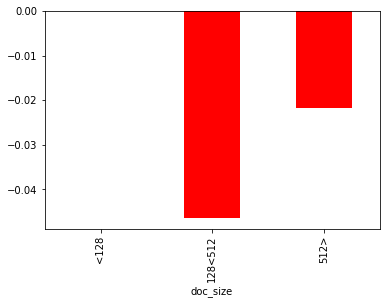

In [44]:

(
    results.assign(sim_diff=results["long_sim"] - results["sbert_sim"])
    .assign(doc_size=pd.cut(results["doc_len"], doc_size_bins, labels=doc_size_names))
    .groupby("doc_size")["sim_diff"]
    .mean()
    .plot(kind="bar", color='red')
)


### Comparação de Similaridade do Embedding dos Documentos com as key-phrase Gold.

Setup

* Dataset: DUC2001
* Modelo sbert = “paraphrase-multilingual-mpnet-base-v2”
* Modelo slong = to_longformer(“paraphrase-multilingual-mpnet-base-v2”, max_lenght=4096, attention_window=512)

DOC 	1:n 		Gold_Kp




In [5]:
dataset = load_data("DUC2001", geo_kpe_multidoc.GEO_KPE_MULTIDOC_DATA_PATH)
sbert = SentenceTransformer(
    "paraphrase-multilingual-mpnet-base-v2"
)
slong = SentenceEmbedder(
    *to_longformer_t_v4(SentenceTransformer("paraphrase-multilingual-mpnet-base-v2"))
)
del slong.model.embeddings.token_type_ids


2023-04-26 11:06:20.322 | INFO     | geo_kpe_multidoc.models.backend._longmodels:to_longformer_t_v4:195 - Transform SentenceTransformer to longformer using Transformers v 4.26


doc_sim = similaridade embedding do documento via sbert com embedding via slong

sbert_sim = similaridade embedding documento com embedding do candidato (sbert)

long_sim = similaridade embedding documento com embedding do candidato (long)

mean_in_doc_sim = similaridade embedding documento (slong) com a media dos embeddings dos tokens do candidato quando existe no documento.

In [6]:
sim(doc, gold)

,doc_len,doc_sim,candidate,sbert_sim,long_sim,mean_in_doc_sim
0,352,0.748711,illegal aliens,0.531638,0.439952,0.653616
1,352,0.748711,1990 census,0.409954,0.421071,NaN
2,352,0.748711,census bureau,0.549789,0.462613,NaN
3,352,0.748711,american immigration reform,0.554424,0.534275,NaN
4,352,0.748711,house apportionment,0.342412,0.354594,NaN
5,352,0.748711,national head count,0.425025,0.333445,0.721379


In [29]:
results = pd.DataFrame()
# for id, doc, gold in islice(tqdm(dataset), 0, 3):
for id, doc, gold in tqdm(dataset):
    r = sim(doc, gold)
    r['id'] = id
    results = pd.concat([results, r])

100%|██████████| 308/308 [1:11:11<00:00, 13.87s/it]


In [32]:
# results.to_csv(os.path.join(geo_kpe_multidoc.GEO_KPE_MULTIDOC_OUTPUT_PATH, "DUC2001-GoldToDoc-sim-sbert-slong.csv"))

Tamanho dos Documentos (n_tokens). Foram definidas 3 categorias. Vemos que há poucos documentos pequenos “<128” tokens, e a maioria são grandes com mais de 512 tokens.

<AxesSubplot:>

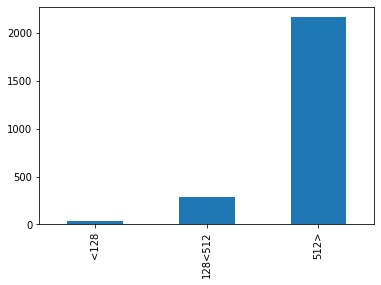

In [43]:
doc_size_bins = [0, 128, 512, np.inf]
doc_size_names = ["<128", "128<512", "512>"]

(
    results.assign(sim_diff=results["long_sim"] - results["sbert_sim"])
    .assign(doc_size=pd.cut(results["doc_len"], doc_size_bins, labels=doc_size_names))[
        "doc_size"
    ]
    .value_counts()
    .sort_index()
    .plot(kind="bar")
)


Para cada modelo (sbert, slong) é calculada a semelhança (cos_sim) entre o Embedding do Doc e embedding de cada Key-Phrase. O embedding das keyphrase gold é calculado sem o contexto do documento, apenas o.

Se um dos modelos conseguir representar bem o documento e as keyphrases reais na mesma região do espaço de embedding, então obtemos semelhanças predominantemente maiores que as obtidas com base no outro modelo.

Calculando a diferença entre das duas similaridades obtidas com base nos dois modelos, no caso (sim_via_slong - sim_via_sbert), obtemos o gráfico. 
* Vermelho semelhança via slong menor que semelhança via sbert
* Verde semelhança via slong menor que semelhança via sbert

Mais vermelhos que verdes. Mais de 50% das similaridades entre cada documento e as suas keyphrases calculadas com base no modelo sbert são maiores que as calculadas com base no modelo slong.


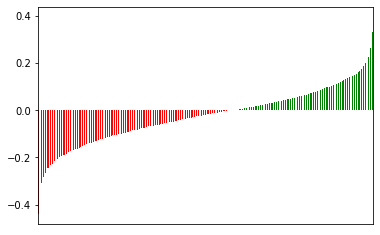

In [65]:
results['sim_diff'] = results["long_sim"] - results["sbert_sim"]
results = results.sort_values('sim_diff')
results['perf_color'] = results['sim_diff'].map(lambda z: "green" if z > 0 else "red")
results.plot(kind='bar', y='sim_diff', color=results['perf_color'], xticks=None)
plt.xticks([])
plt.legend('', frameon=False)
plt.show()

### Comparação de Embeddings em dois textos exemplo não relacionados

In [66]:
doc1 = "Humans evolved as hunters and gatherers where we all worked for ourselves. It’s only at the beginning of agriculture we became more hierarchical. The Industrial Revolution and factories made us extremely hierarchical because one individual couldn’t necessarily own orbuild a factory, but now, thanks to the internet, we’re going back to an age where more and more people can work for themselves. I would rather be a failed entrepreneur than someone who never tried. Because even a failed entrepreneur has the skill set to make it on their own"

doc2 = "He remembered how once he had been walking down a crowded street when a tremendous shout of hundreds of voices women's voices—hadburst from a side-street a little way ahead. It was a great formidable cry of anger and despair, a deep, loud 'Oh-o-o-o-oh!' that went humming on like the reverberation of a bell. His heart had leapt. It's started! he had thought. A riot! The proles are breaking loose at last! When he had reached the spot it was to see a mob of two or three hundred women crowding round the stalls of a street market, with facesas tragic as though they had been the doomed passengers on a sinking ship. But at this moment the general despair broke down into a multitude of individual quarrels. It appeared that one of the stalls had been selling tin saucepans. They were wretched, flimsy things, but cooking-pots of any kind were always difficult to get. Now the supply had unexpectedly given out. The successful women, bumped and jostled bythe rest, were trying to make off with their saucepans while dozens of others clamoured round the stall, accusing the stall-keeper of favouritism and of having more saucepans somewhere in reserve. There was a fresh outburst of yells. Two bloated women, one of them with her hair coming down, had got hold of the same saucepan and were trying to tear it out of one another's hands. For a moment they were both tugging, and then the handle came off. Winston watched them disgustedly. And yet, just for a moment, what almost frightening power had soundedin that cry from only a few hundred throats! Why was it that they could never shout like that about anything that mattered?"


In [73]:
sim_docs(doc1, doc2, slong), sim_docs(doc1, doc2, sbert)

(0.1974828690290451, 0.08310921490192413)

Similaridade da junção dos dois textos.

In [74]:
sim_docs(doc1+doc2, doc2, slong), sim_docs(doc2+doc1, doc2, slong)

(0.900473415851593, 0.9357936978340149)

Comparação entre embeddings do mesmo documento com conceitos que surgem alem do limite 128 tokens.

In [76]:
sim_docs("Winston", doc2, slong), sim_docs("Winston", doc2, sbert)

(0.21294032037258148, 0.25201719999313354)

In [79]:
sim_docs("Winston watched them disgustedly.", doc2, slong), sim_docs("Winston watched them disgustedly.", doc2, sbert)

(0.20602044463157654, 0.2406032383441925)

In [82]:
doc2[:368]

"He remembered how once he had been walking down a crowded street when a tremendous shout of hundreds of voices women's voices—hadburst from a side-street a little way ahead. It was a great formidable cry of anger and despair, a deep, loud 'Oh-o-o-o-oh!' that went humming on like the reverberation of a bell. His heart had leapt. It's started! he had thought. A riot! "

In [83]:
doc2[450:600]

'a mob of two or three hundred women crowding round the stalls of a street market, with facesas tragic as though they had been the doomed passengers on'

In [85]:
sim_docs("doomed", doc2[:600], slong), sim_docs("doomed", doc2[:600], sbert)

(0.1831817328929901, 0.11783720552921295)

Comparação com texto não relacionado.

In [86]:
sim_docs("Lisboa", doc2[:600], slong), sim_docs("Lisboa", doc2[:600], sbert)

(0.08899366855621338, 0.06737534701824188)

In [87]:
sim_docs("Lisboa", doc2[:368], slong), sim_docs("Lisboa", doc2[:368], sbert)

(0.05912849307060242, 0.05912855267524719)